# **Analyse exploratoire des données**

Avant de passer à la prédiction, nous allons tout d'abord analyser la structure des données et constater ce qu'il faut traiter. La première étape est la vérification des valeurs manquantes.

## Création des DataFrames et d'une fonction qui repère les valeurs manquantes

In [6]:
import pandas as pd
train = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/train.csv")
test = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/test.csv")


def missing_values_table(df):
    #Analyse des types des variables
    type = df.dtypes
    nb_unique = df.nunique()
    #Toutes les valeurs omises
    mis_val = df.isnull().sum()
    #Pourcentage des valeurs omises
    mis_val_pct = 100 * df.isna().sum() / len(df)
    #Création d'une table avec ces données
    mis_val_table = pd.concat([mis_val, mis_val_pct, type, nb_unique], axis=1)
    #Modification du nom des colonnes
    mis_val_table_rename_columns = mis_val_table.rename(
        columns={0: "Valeurs manquantes", 1: "% des valeurs manquantes", 2: "Type de la variable", 3: "Nombres uniques"})
    #Le classement des colonnes avec le plus de valeurs manquantes
    mis_val_table_rename_columns = mis_val_table_rename_columns[mis_val_table_rename_columns.iloc[:,1]!=0].sort_values('% des valeurs manquantes', ascending=False).round(1)
    #La phrase qui resume l'état des colonnes
    if mis_val.sum() > 0:
        print(f"Le dataframe sélectionné contient {df.shape[1]} colonnes.\n"
        f"Il y a {mis_val_table_rename_columns.shape[0]} colonnes avec des valeurs manquantes.")
        #Return le dataframe avec les données manquantes
        return mis_val_table_rename_columns
    else:
        print("La base de données est nettoyée")
        return None


### Vérification de train.csv

In [7]:
missing_values_table(train)

Le dataframe sélectionné contient 20 colonnes.
Il y a 11 colonnes avec des valeurs manquantes.


,Valeurs manquantes,% des valeurs manquantes,Type de la variable,Nombres uniques
Tryglicerides,8370,55.8,float64,153
Cholesterol,8331,55.5,float64,210
Copper,6548,43.7,float64,170
SGOT,6445,43.0,float64,201
Spiders,6445,43.0,object,2
Alk_Phos,6442,42.9,float64,387
Ascites,6437,42.9,object,4
Hepatomegaly,6436,42.9,object,3
Drug,6436,42.9,object,2
Platelets,586,3.9,float64,267


### Vérification de test.csv

In [8]:
missing_values_table(test)

Le dataframe sélectionné contient 19 colonnes.
Il y a 12 colonnes avec des valeurs manquantes.


,Valeurs manquantes,% des valeurs manquantes,Type de la variable,Nombres uniques
Tryglicerides,5593,55.9,float64,152
Cholesterol,5562,55.6,float64,210
Copper,4396,44.0,float64,164
SGOT,4344,43.4,float64,193
Alk_Phos,4340,43.4,float64,348
Spiders,4340,43.4,object,3
Drug,4340,43.4,object,3
Hepatomegaly,4335,43.4,object,2
Ascites,4334,43.3,object,2
Platelets,375,3.8,float64,257


Nous pouvons constater le fait que le taux de valeurs manquantes est très élevé. Il existe deux choix : soit nous supprimons ces lignes, ce qui aura pour résultat une perte énorme d'information, ou bien on creuse davantage pour comprendre la raison de leur absence.
Il est également important à préciser que train a une colonne de plus que test, ce qui attendu, étant donné qu'on souhaite entrainer notre modèle à prédire les probabilités du devenir du patient. 

## Visualisation des données avec la librairie *missingno*

La question se pose sur la corrélation entre les variables manquantes.

<Axes: >

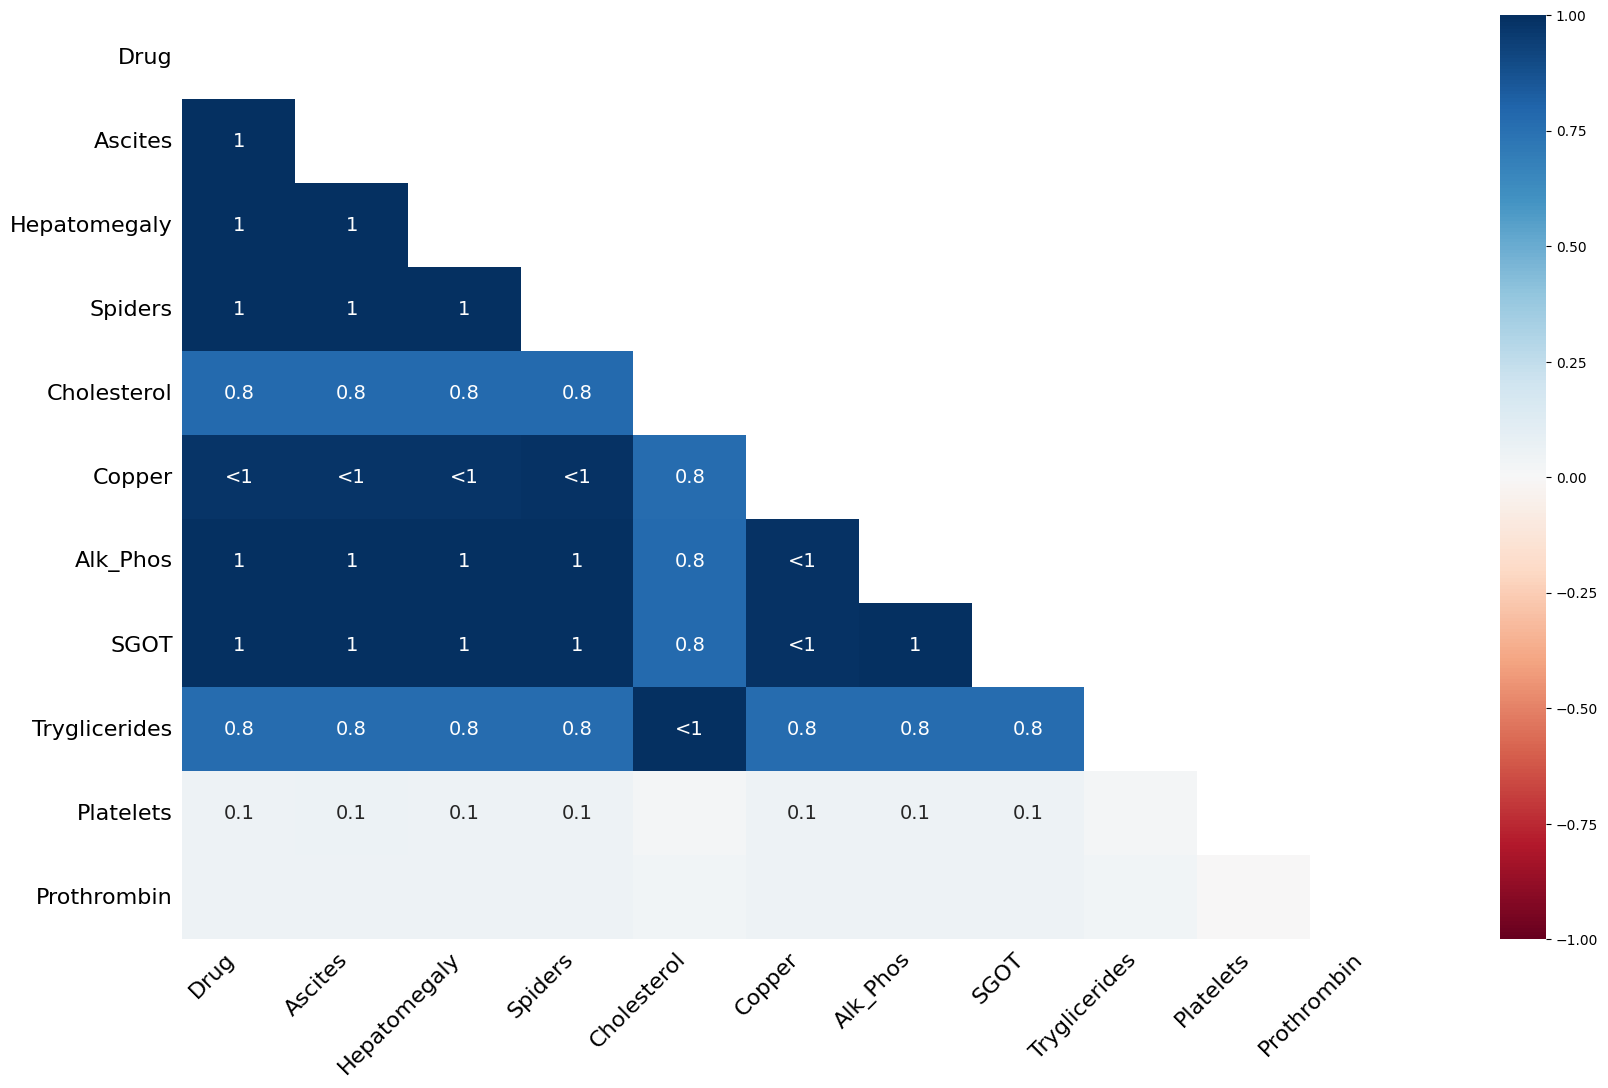

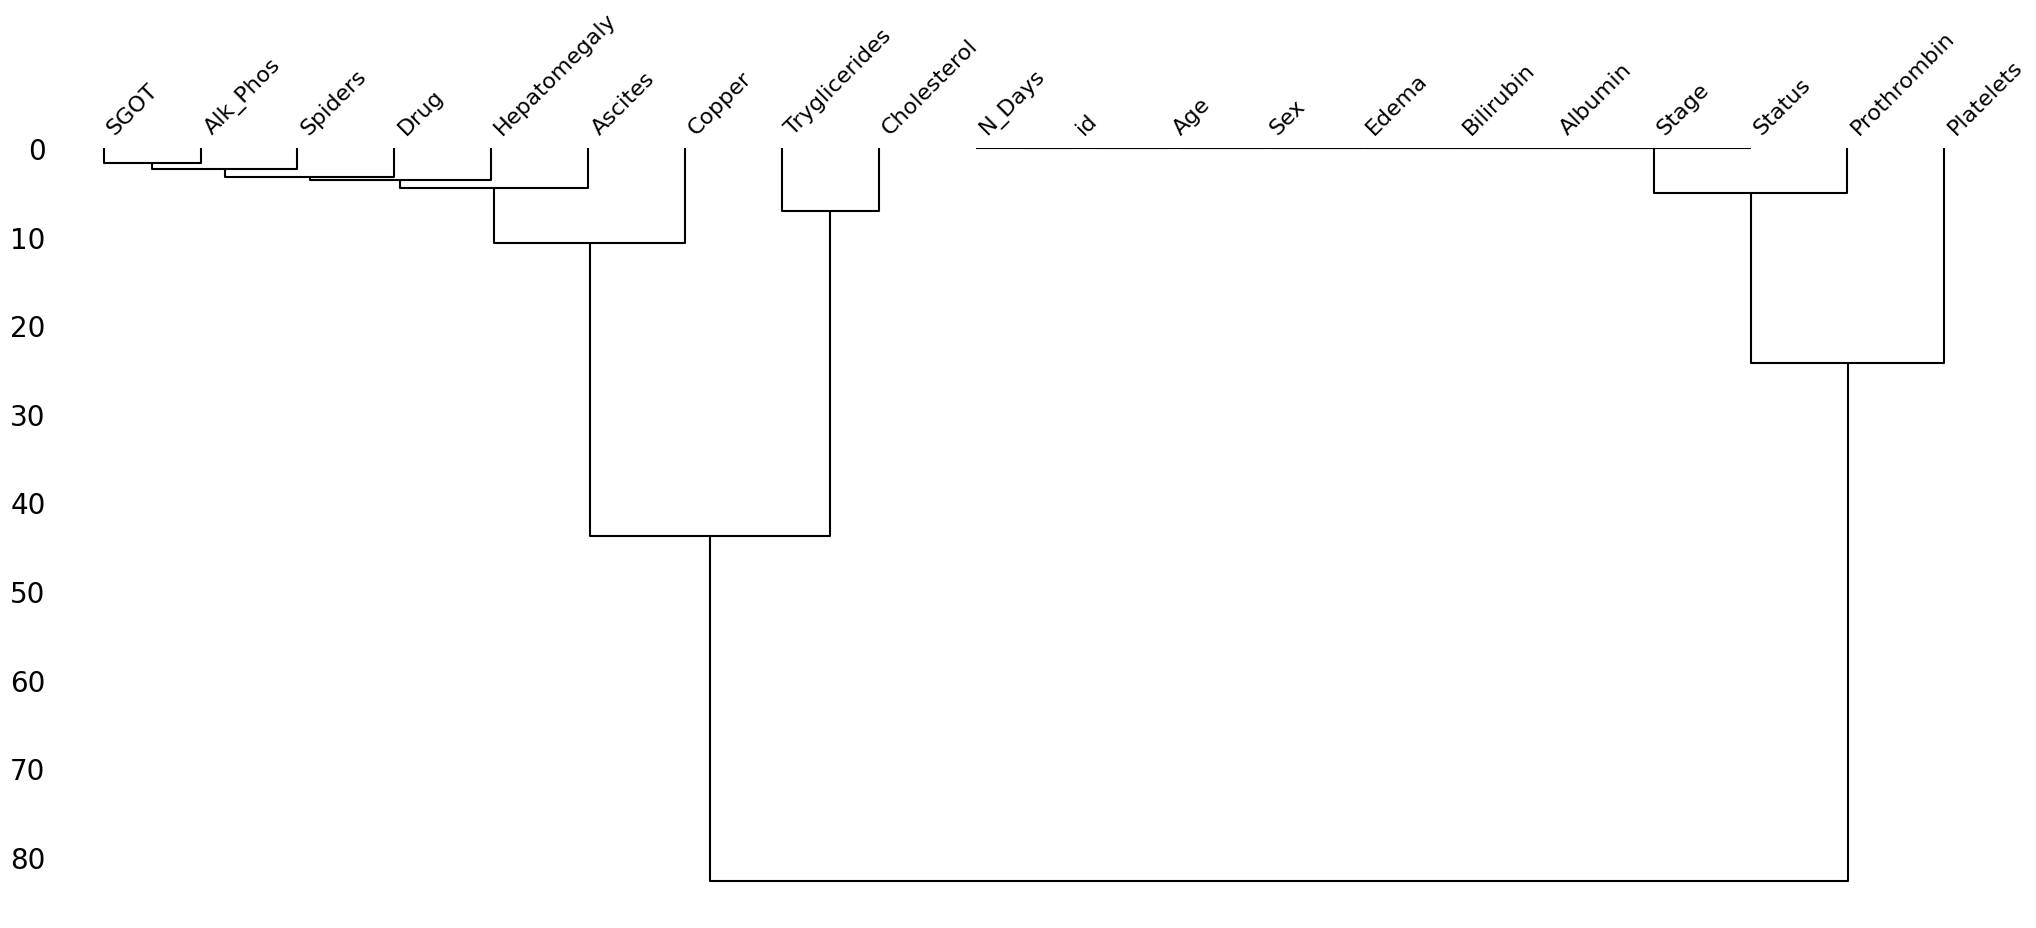

In [9]:
import missingno as msno

sort_train = train.sort_values( by=["Tryglicerides", "Cholesterol", "Copper", "SGOT","Spiders","Alk_Phos","Ascites","Hepatomegaly","Drug","Platelets","Prothrombin"])
msno.heatmap(sort_train)
msno.dendrogram(sort_train)

Une corrélation de 1 signifie que lorsqu'il existe une valeur manquante chez Drug, alors c'est presque sûrement le même cas pour Ascites.

En ce qui concerne le dendrogramme, SGOT, Alk_Phos, Spiders, Drug, Hepatomegaly et Ascites sont souvent manquantes ensemble, signifiant soit un examen en commun, ou une même visite. Pareil pour Copper, Tryglicerides et Cholesterol. Platelets, Prothrombin et le reste, sont le plus probablement des valeurs manquantes indépendantes. 

On en déduit que c'est le même cas pour les variables de la base test. Une imputation par "Inconnu" pour les variables catégorielles (dtypes : object), et une médiane pour celles numériques (dtypes : int64, float64) semble pertinent. En effet, le choix de la médiane a été fait après avoir observé le fort skewness des variables numériques. (voir **Annexes**)

Puisque souvent les mêmes variables sont absentes chez les individus, on peut exploiter cette information pour gagner en puissance prédictive - nous pouvons utiliser une indicatrice valant 1 si les variables concernées étaient manquantes chez les individus, et 0 sinon. De plus, on peut imputer une médiane aux valeurs manquantes indépendantes, en raison de leur non significativité. 
Avec cette information, on peut passer au nettoyage des données, et à la construction des modèles prédictifs.

**Ci-dessous se trouve le modèle avec le meilleur score** (la log_loss la moins élevée). En **annexes**, vous pourrez retrouver les autres modèles testés et non retenus en raison de leur moindre performance. 

# Le modèle gagnant : XGBoost

Afin d'éviter au maximum l'overfitting du modèle, et notamment des paramètres choisis, nous avons vérifié les performances par une validation croisée en 10 tranches. Dans ce sens, nous avons également opté pour un modèle moins profond (max_depth) des arbres.

**La performance** est mesurée par rapport à la moyenne et l'écart-type de la validation croisée **en bas du programme**.

In [23]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
############################################################################################################
train = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/train.csv")
test = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/test.csv")
############################################################################################################

X = train.drop(columns=["Status", "id"]) # Apparemment "id" était pris en compte dans l'apprentissage
y = train["Status"]
test_X = test.drop(columns=["id"])

# XGB nécessite les y numériques - transformation des Status en variables numériques 
LE = LabelEncoder()
y_encoded = LE.fit_transform(y)

# ------------------ Constitution du Pipeline (généralise le néttoyage des données) ------------------------ 
# On fait la distinction entre les variables numériques et celles catégorielles
col_num = X.select_dtypes(include=["int64", "float64"]).columns
col_cat = X.select_dtypes(include=["object"]).columns
# Le néttoyage des données par imputation (médiane+indicateur/"Inconnu")
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True)), ])
cat_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Inconnu")),
                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
# OneHotEncoder ignore les valeurs qui n'ont pas été rencontrées lors de l'entrainement 
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, col_num),
        ("cat", cat_pipeline, col_cat),
    ],
    remainder="drop"
)
# ------------------------------------- Constitution du modèle -------------------------------------
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_estimators=600,
    learning_rate=0.06,
    max_depth=4,
    subsample=0.6,
    colsample_bytree=0.5,
    reg_alpha=0,
    reg_lambda=5,
    random_state=42,
    n_jobs=-1,
    min_child_weight=5,
    gamma=0.6,
    tree_method="hist"
)

model_xgb = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ("xgb", xgb)
    ]
)

# --------------------------------------- Cross-validation -------------------------------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
score = cross_val_score(model_xgb, X, y_encoded, cv=cv, n_jobs=-1, scoring="neg_log_loss")
print(f"Log loss par fold : {-score}")
print(f"Log loss moyen : {-score.mean()}")
print(f"Log loss std : {score.std()}")
# ----------------------------------------------------------------------------------------------------------
# Entrainement du modèle sur l'ensemble train
model_xgb.fit(X, y_encoded)
# Prédiction des probabilités des classes en fonction de l'ensemble train (ne contenant pas la variable Status)
probas = model_xgb.predict_proba(test_X)

# --------------------------------------- Indices et submit ------------------------------------------------
idx_C  = np.where(LE.classes_ == "C")[0][0]
idx_CL = np.where(LE.classes_ == "CL")[0][0]
idx_D  = np.where(LE.classes_ == "D")[0][0]

submission = pd.DataFrame({
    "id": test["id"],
    "Status_C":  probas[:, idx_C],
    "Status_CL": probas[:, idx_CL],
    "Status_D":  probas[:, idx_D],
})
# Transformation des données en format .csv
submission.to_csv("/kaggle/working/submission.csv", index=False)


Log loss par fold : [0.38259667 0.33287742 0.36803274 0.3415911  0.37863365 0.3660337
 0.35895337 0.37288334 0.35537536 0.3650429 ]
Log loss moyen : 0.3622020254072583
Log loss std : 0.014827945071241279


# Annexes

## Quelques essais d'amélioration sans effet significatif
### Choix entre moyenne et médiane
Nous avons essayé de diminuer la log_loss par d'autres moyens également. La question du choix entre l'imputation des valeurs manquantes par la moyenne ou celle avec la médiane a été facilement répondue lorsqu'on a constaté les valeurs extrêmes des variables et leur skewness.

En voici une illustration :

In [15]:
import pandas as pd
############################################################################################################
train = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/train.csv")
test = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/test.csv")
############################################################################################################
## On cherche à prédire Status (Y) en fonction des variables explicatives (X)
X = train.drop(columns=["Status", "id"])
y = train["Status"]
test_X = test.drop(columns=["id"])

Cholesterol = X["Cholesterol"].describe()
q1 = X["Cholesterol"].quantile(0.25)
q3 = X["Cholesterol"].quantile(0.75)
iqr = q3 - q1
print(q1, q3, iqr)
print(f"=========== \nStats des : \n===========\n{Cholesterol}")
print(f"\n=========== \nSkewness : \n===========")
col_num = X.select_dtypes(include=["int64", "float64"]).columns
X[col_num].skew().sort_values(ascending=False)

242.0 360.0 118.0
Stats des : 
count    6669.000000
mean      327.670115
std       179.801705
min       120.000000
25%       242.000000
50%       280.000000
75%       360.000000
max      1790.000000
Name: Cholesterol, dtype: float64

Skewness : 


SGOT             7.866655
N_Days           6.404825
Cholesterol      4.504865
Bilirubin        4.127208
Alk_Phos         3.212749
Copper           3.099731
Tryglicerides    2.346326
Prothrombin      1.473345
Platelets        0.527312
Age             -0.258954
Albumin         -0.277559
Stage           -0.485748
dtype: float64

### Classes de sortie équilibrées
Nous avons constaté (illustré ci-dessous) que les proportion des classes de sortie ne sont pas égales. Dans ce sens, nous avons essayé d'utiliser class="balanced" dans les paramètres du modèle, toutefois cette modification dégradait les résultats.

In [16]:
y.value_counts(normalize=True)*100

Status
C     66.993333
D     30.400000
CL     2.606667
Name: proportion, dtype: float64

### Une alternative pour les valeurs extrêmes
Nous avons également essayé de diminuer le risque éventuel des valeurs extrêmes en appliquant le log sur des variables comme SGOT, Cholesterol etc. L'effet est inobservable, le plus probablement en raison du fait que les modèles traitent ces valeurs par construction. Ainsi nous avons laissé cette idée. 




## Les autres modèles évalués

Les résultats ont été fondés sur la moyenne et l'écart-type de la validation croisée, qui sont indiqués en bas du programme. 

### Random Forest

Il s'agit du **premier modèle** essayé, en s'inspirant du cours.

In [17]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
############################################################################################################
train = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/train.csv")
test = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/test.csv")
############################################################################################################

X = train.drop(columns=["Status", "id"])
y = train["Status"]
X_test = train.drop(columns=["id"])

col_num = X.select_dtypes(include=["int64", "float64"]).columns
col_cat = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True)),])
cat_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Inconnu")),("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, col_num),
        ("cat", cat_pipeline, col_cat),
    ],
    remainder="drop"
)

# Le modèle RandomForest
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
model_rf = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])
# La cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model_rf,
                         X,
                         y,
                         cv=cv,
                         scoring="neg_log_loss",
                         n_jobs=-1)
print(f"RF score: {-scores}")
print(f"Log loss moyenne : {-scores.mean()}")
print(f"Ecart-type log loss : {scores.std()}")
model_rf.fit(X, y)
# La proba de status
proba_valid = model_rf.predict_proba(X_test)





RF score: [0.40841787 0.37457935 0.4281207  0.3738331  0.42966818 0.41227884
 0.42988549 0.42433171 0.39138836 0.43522091]
Log loss moyenne : 0.41077244997809637
Ecart-type log loss : 0.022052009541239443


### Histogram Gradient Boosting

Il s'agit du **deuxième modèle** essayé, en s'inspirant également du cours. Ses résultats ont été significativement meillerurs que ceux de Random Forest.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
############################################################################################################
train = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/train.csv")
test = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/test.csv")
############################################################################################################

X = train.drop(columns=["Status", "id"])
y = train["Status"]
test_X = test.drop(columns=["id"])

col_num = X.select_dtypes(include=["int64", "float64"]).columns
col_cat = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True)), ])
cat_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Inconnu")),
                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, col_num),
        ("cat", cat_pipeline, col_cat),
    ],
    remainder="drop"
)

# Le modèle HistogramGradientBoosting
hgb = HistGradientBoostingClassifier(loss="log_loss",
                                     learning_rate=0.05,
                                     max_depth=5,
                                     random_state=42,
                                     max_iter=700,
                                     ) #class_weight="balanced" empire la log loss

model_hgb = Pipeline(steps=[("preprocess", preprocess),
                            ("model", hgb)])

# La cross validation
cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(
    model_hgb,
    X,
    y,
    cv=cross_val,
    scoring="neg_log_loss",
    n_jobs=-1,
)
print(f"Log loss par fold : {-scores}")
print(f"Log loss en moyenne : {-scores.mean()}")
print(f"Ecart-type : {scores.std()}")

# L'entrainement des données train
model_hgb.fit(X, y)
# Proba sur l'ensemble de test
probas_hgb = model_hgb.predict_proba(test_X)



Log loss par fold : [0.39816234 0.35663216 0.38591443 0.35451228 0.39507024 0.38672278
 0.37288876 0.39677617 0.37494881 0.38620322]
Log loss en moyenne : 0.38078311771771745
Ecart-type : 0.014908757074784918


### LightGBM

Il s'agit du **troisème modèle** essayé. Puisqe la base de données contient des variables catégorielles, nous avons pensé que probablement utiliser un modèle spécialement conçu pour ce type de variables pourrait améliorer le score. Cela n'a pas été le cas.

Son résultat n'est pas indiqué ci-dessous car le programme tourne à l'infini sur Kaggle alors que sur un ordinateur normal les calculs sont faits en quelques secondes.

Par consqéqent, voici les résultats collés ici :

Log loss par fold : [0.39256295 0.34822427 0.39764714 0.36452938 0.39652845 0.39673875
 0.37378659 0.40009557 0.38206408 0.38574012]
 
Log loss en moyenne : 0.3837917303239386

Ecart-type : 0.016147870403033112

In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
from sklearn.exceptions import DataConversionWarning
import os
warnings.filterwarnings("ignore", message="X does not have valid feature names*")
os.environ["LIGHTGBM_VERBOSE"] = "-1"
warnings.filterwarnings("ignore", category=DataConversionWarning)
############################################################################################################
train = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/train.csv")
test = pd.read_csv("/kaggle/input/master-econometrie-et-statistiques/test.csv")
############################################################################################################

X = train.drop(columns=["Status", "id"])
y = train["Status"]
test_X = test.drop(columns=["id"])

LE = LabelEncoder()
y_encoded = LE.fit_transform(y)

num_col = X.select_dtypes(include=["int64", "float64"]).columns
cat_col = X.select_dtypes(include=["object"]).columns

numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
])
categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Inconnu')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('numeric', numeric, num_col),
        ('categorical', categorical, cat_col),
    ],
    remainder='drop'
)

# Le modèle LightGBM : 
lgbm = LGBMClassifier(
    objective="multiclass",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_lgbm = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', lgbm)
    ]
)

# La cross-validation 
cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model_lgbm,
                            X,
                            y_encoded,
                            cv=cv,
                            n_jobs=-1,
                            scoring='neg_log_loss')
print(f"Log loss par fold : {-scores}")
print(f"Log loss en moyenne : {-scores.mean()}")
print(f"Ecart-type : {scores.std()}")

### L'entrainement du modèle + la prédiction de la proba C, CL, D #################################
model_lgbm.fit(X,y_encoded)
probas_lgbm = model_lgbm.predict_proba(test_X)

